In [49]:
import json
import math
import pickle

import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

import utils

In [50]:
dataset_path = "../datasets/UrbanVehicle"
data_path = "./data"

## Create road graph as networkx DiGraph
road_graph = nx.DiGraph()
with open(f"{dataset_path}/map.json", mode="r", encoding="utf-8") as file:
    items = json.load(file)

    for item in items:
        if item["type"] == "node":
            road_graph.add_node(item["id"], pos=(item["xy"][0], item["xy"][1]))

    edge_id = 0
    for item in items:
        if item["type"] == "way":
            nodes = item["nodes"]
            is_oneway = item["oneway"]

            for u, v in zip(nodes, nodes[1:]):
                road_graph.add_edge(u, v, id=edge_id)
                edge_id += 1
                if not is_oneway:
                    road_graph.add_edge(v, u, id=edge_id)
                    edge_id += 1

# Remove self-loops from road graph
# Nodes with self-loops: 64, 74, 192, 193, 198, 255, 262, 272, 277, 442, 448, 505, 595, 653, 829, 872, 1035, 1052, 1054, 1055, 1150
road_graph.remove_edges_from(nx.selfloop_edges(road_graph))

# Add Euclidean distances to edges of road graph
for u, v in road_graph.edges():
    u_x, u_y = road_graph.nodes[u]["pos"]
    v_x, v_y = road_graph.nodes[v]["pos"]
    distance = math.sqrt((v_x - u_x) ** 2 + (v_y - u_y) ** 2)
    road_graph.edges[u, v]["weight"] = distance

# Save road graph
with open(f"{data_path}/road_graph_nsl.pickle", mode="wb") as file:
    pickle.dump(road_graph, file)

print("Road Graph: ", road_graph)

# Check connectivity
# Non-connected nodes: 2336, 6817, 2341, 2247, 1512, 2248, 5289, 2795, 2796, 1520, 7857, 2262, 7448, 2333
# Non-connected edges: 9344, 10424
print("Road graph is strongly connected: ", nx.is_strongly_connected(road_graph))
print("Road graph is weakly connected: ", nx.is_weakly_connected(road_graph))

Road Graph:  DiGraph with 8270 nodes and 10186 edges
Road graph is strongly connected:  False
Road graph is weakly connected:  False


In [51]:
# Find maximum strongly- and weakly-connected sub road graph
wccs = list(nx.weakly_connected_components(road_graph))
max_wcc = max(wccs, key=len)
max_wcc_sub_road_graph = road_graph.subgraph(max_wcc).copy()

sccs = list(nx.strongly_connected_components(road_graph))
max_scc = max(sccs, key=len)
max_scc_sub_road_graph = road_graph.subgraph(max_scc).copy()

print("Road Graph (strongly-connected): ", max_scc_sub_road_graph)

# Save strongly-connected sub road graph
with open(f"{data_path}/road_graph_nsl_sc.pickle", mode="wb") as file:
    pickle.dump(max_scc_sub_road_graph, file)

Road Graph (strongly-connected):  DiGraph with 6634 nodes and 8464 edges


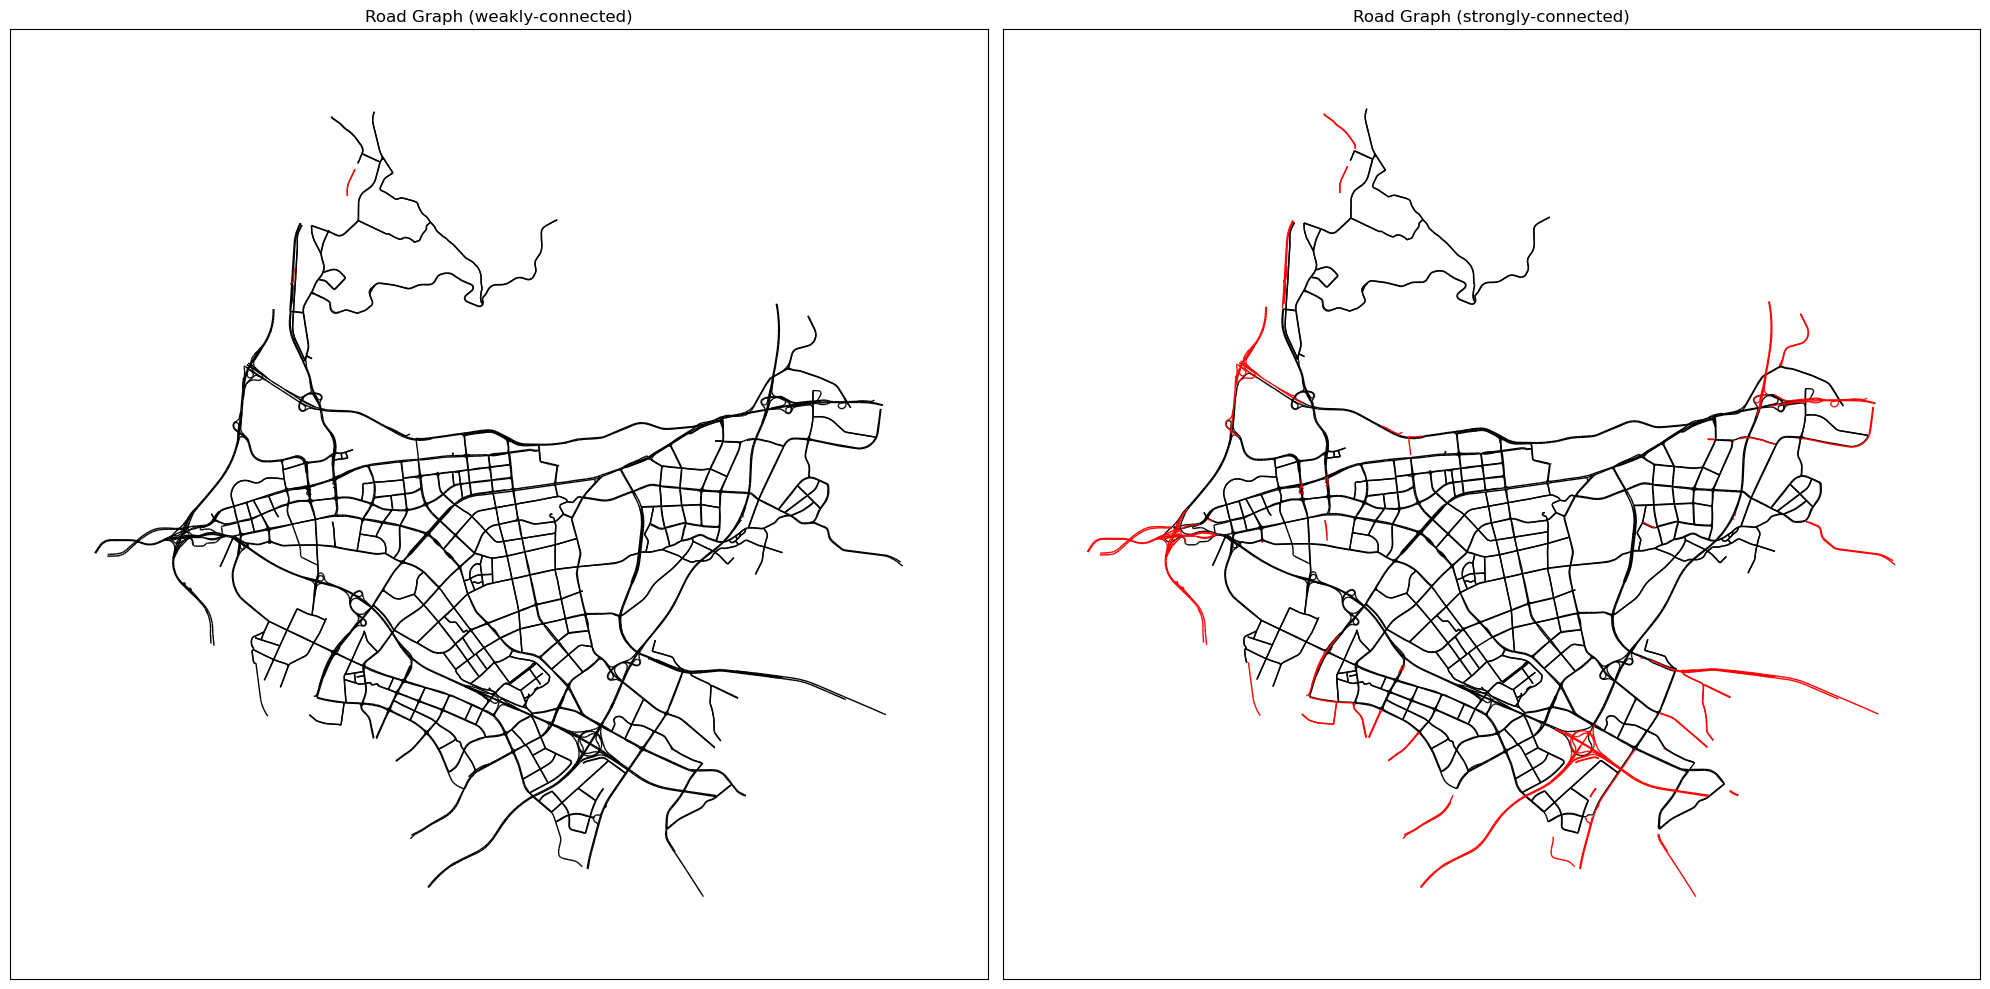

In [52]:
## Draw the road graph
pos = nx.get_node_attributes(road_graph, "pos")

# Find sub road graphs consisting of strongly- and weakly-connected components that are not the maximum one
left_out_wcc_nodes = set(road_graph.nodes()) - set(max_wcc_sub_road_graph.nodes())
left_out_wcc_sub_road_graph = road_graph.subgraph(left_out_wcc_nodes)

left_out_scc_nodes = set(road_graph.nodes()) - set(max_scc_sub_road_graph.nodes())
left_out_scc_sub_road_graph = road_graph.subgraph(left_out_scc_nodes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

nx.draw_networkx_edges(
    max_wcc_sub_road_graph,
    pos,
    arrows=False,
    ax=ax1
)
nx.draw_networkx_edges(
    left_out_wcc_sub_road_graph,
    pos,
    edge_color="red",
    arrows=False,
    ax=ax1
)
ax1.set_title("Road Graph (weakly-connected)")

nx.draw_networkx_edges(
    max_scc_sub_road_graph,
    pos,
    arrows=False,
    ax=ax2
)
nx.draw_networkx_edges(
    left_out_scc_sub_road_graph,
    pos,
    edge_color="red",
    arrows=False,
    ax=ax2
)
ax2.set_title("Road Graph (strongly-connected)")

plt.tight_layout()
plt.show()

In [53]:
# Fetch OSMnx graph
road_graph_ox = ox.graph_from_bbox(bbox=(113.95088, 22.57502, 114.08323, 22.71175), network_type="drive",
                                   simplify=False)

print("Road Graph OSMnx: ", road_graph_ox)

road_graph_ox = ox.add_edge_speeds(road_graph_ox)
road_graph_ox = ox.add_edge_travel_times(road_graph_ox)

# Remove self-loops
road_graph_ox.remove_edges_from(nx.selfloop_edges(road_graph_ox))

# Save OSMnx road graph
ox.save_graphml(road_graph_ox, filepath=f"{data_path}/road_graph_ox_nsl.xml", encoding="utf-8")
# road_graph_ox = ox.load_graphml(filepath=f"{data_path}/road_graph_ox_nsl.xml")

road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_32650)

road_graph_ox = ox.simplify_graph(road_graph_ox, track_merged=True)
road_graph_ox = ox.consolidate_intersections(road_graph_ox, tolerance=20, rebuild_graph=True, dead_ends=True,
                                             reconnect_edges=True)

print("Road Graph OSMnx (sim, con): ", road_graph_ox)

road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_4326)
ox.save_graphml(road_graph_ox, filepath=f"{data_path}/road_graph_ox_sim_con_nsl.xml", encoding="utf-8")

# wccs = nx.weakly_connected_components(road_graph_ox)
# max_wcc = max(wccs, key=len)
# max_wcc_sub_road_graph = road_graph_ox.subgraph(max_wcc).copy()

sccs = nx.strongly_connected_components(road_graph_ox)
max_scc = max(sccs, key=len)
max_scc_sub_road_graph = road_graph_ox.subgraph(max_scc).copy()

print("Road Graph OSMnx (sim, con, strongly-connected): ", max_scc_sub_road_graph)

ox.save_graphml(max_scc_sub_road_graph, filepath=f"{data_path}/road_graph_ox_sim_con_nsl_sc.xml", encoding="utf-8")

Road Graph OSMnx:  MultiDiGraph with 41454 nodes and 58921 edges
Road Graph OSMnx (sim, con):  MultiDiGraph with 3776 nodes and 8585 edges
Road Graph OSMnx (sim, con, strongly-connected):  MultiDiGraph with 3577 nodes and 8280 edges


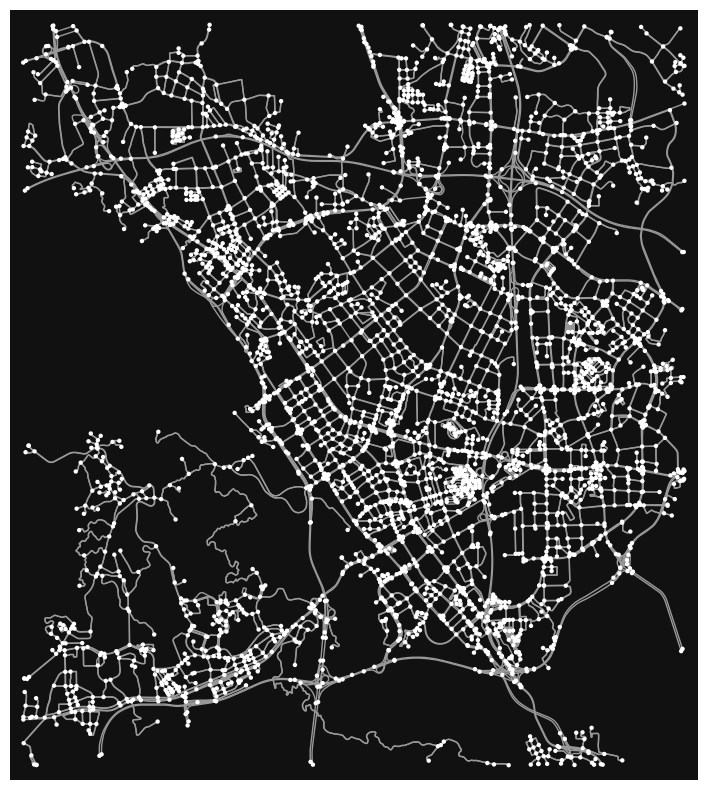

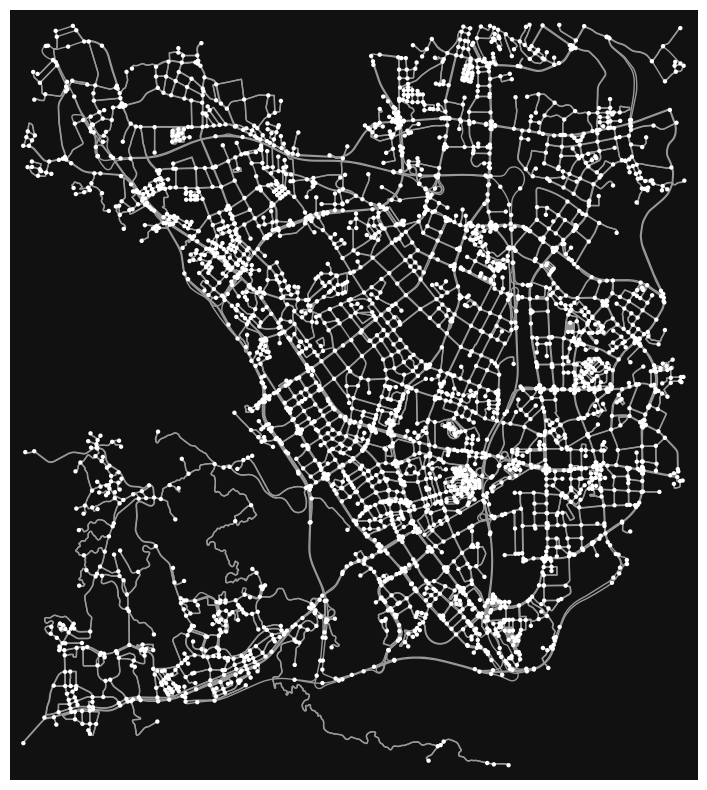

In [54]:
## Draw the road graph
pos = {node: (road_graph_ox.nodes[node]["x"], road_graph_ox.nodes[node]["y"]) for node in road_graph_ox.nodes()}

fig, ax = ox.plot_graph(
    road_graph_ox,
    node_size=10,
    figsize=(10, 10)
)
ax.set_title("Road Graph OSMnx (sim, con)")

# fig, ax = ox.plot_graph(
#     max_wcc_sub_road_graph,
#     node_size=10,
#     figsize=(10, 10)
# )
# ax.set_title("Road Graph OSMnx (weakly-connected) (sim, con)")

fig, ax = ox.plot_graph(
    max_scc_sub_road_graph,
    node_size=10,
    figsize=(10, 10)
)
ax.set_title("Road Graph OSMnx (strongly-connected) (sim, con)")

plt.show()